# Fraud Detection Models

## Data Processing

In [7]:
# Append system path
import sys, os
sys.path.append(os.path.abspath('../modules'))

# Import pipeline modules
from raw_data_handler import Raw_Data_Handler
from dataset_design import Dataset_Designer
from feature_extractor import Feature_Extractor

# Create Class instances
data_handler = Raw_Data_Handler()
data_designer = Dataset_Designer()
feature_eng = Feature_Extractor()

In [8]:
# Define filepaths
customer_file = "../data_sources/customer_release.csv"
transactions_file = "../data_sources/transactions_release.parquet"
fraud_file = "../data_sources/fraud_release.json"

In [9]:
# Extract raw data from files 
customer_file, transactions_file, fraud_file = data_handler.extract(customer_file, transactions_file, fraud_file)
# Create cleaned raw data dataframe
raw_data = data_handler.transform(customer_file, transactions_file, fraud_file)

In [4]:
# Create train and test set
train_set, test_set = data_designer.sample(raw_data, test_size=0.2)

In [5]:
data_designer.load()

Saved raw dataset to /Users/srikantamehta/Documents/mehta-srikanta/securebank/storage/train_data/processed_raw_data.parquet


In [6]:
# Describe data
data_designer.describe()

{'version': '1.0',
 'storage': '/Users/srikantamehta/Documents/mehta-srikanta/securebank/storage/train_data/processed_raw_data',
 'description': {'training_set_size': 1186297,
  'test_set_size': 296575,
  'feature_count': 21,
  'training_class_distribution': {0.0: 0.9953097748708797,
   1.0: 0.00469022512912028},
  'test_class_distribution': {0.0: 0.9968574559554919,
   1.0: 0.0031425440445081347}}}

In [6]:
# Apply feature engineering to train and test set
X_train, X_test, y_train, y_test, numeric_transformer, target_encoder = feature_eng.transform(train_set, test_set)

In [7]:
feature_eng.describe()

{'version': '1.0',
 'description': {'training_set_size': 1186297,
  'test_set_size': 296575,
  'feature_count': 11,
  'training_class_distribution': {0.0: 0.9953097748708797,
   1.0: 0.00469022512912028},
  'test_class_distribution': {0.0: 0.9968574559554919,
   1.0: 0.0031425440445081347},
  'training_stats': {'amt': {'count': 1186297.0,
    'mean': 2.0769486819251194e-16,
    'std': 1.0000004214798404,
    'min': -0.4453626920667613,
    '25%': -0.3897350087752875,
    '50%': -0.1471905295288964,
    '75%': 0.0851749913529709,
    'max': 187.23582765213544},
   'merch_lat': {'count': 1186297.0,
    'mean': -1.0942074344142647e-16,
    'std': 1.0000004214798879,
    'min': -3.8491502504556494,
    '25%': -0.7392431629755423,
    '50%': 0.163366147962799,
    '75%': 0.6694818413741985,
    'max': 5.393941678966862},
   'merch_long': {'count': 1186297.0,
    'mean': -2.0972054602221283e-15,
    'std': 1.0000004214798732,
    'min': -5.499537823360715,
    '25%': -0.4887983125595708,
   

## Model Evaluation

The function evaluate_model_with_custom_threshold() evaluates a model to find the classification threshold value that maximized f1 score given a minimum precision and recall baseline. We later define three models to evaluate; a Random Forest model, a custom bagged Decision Tree model, and a Multilayer Perceptron Model. The parameters for these models were tuned previously using a combination of cross valiation and iterative changes. This will be described in more detail in the case study documentation.

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import numpy as np

def evaluate_model_with_custom_threshold(model, X_train, y_train, X_test, y_test, precision_min=0.3, recall_min=0.6):
    """
    Trains the provided model, finds the best threshold that maximizes F1-score with constraints on precision and recall,
    and evaluates the model using the custom threshold.
    
    Parameters:
    - model: The machine learning model to be trained and evaluated.
    - X_train: Training features.
    - y_train: Training labels.
    - X_test: Test features.
    - y_test: Test labels.
    - precision_min: Minimum required precision for valid thresholds.
    - recall_min: Minimum required recall for valid thresholds.
    
    Returns:
    - model: The trained model.
    - best_threshold: The best threshold that maximizes F1-score while satisfying the constraints.
    """
    # Train the model on the training data
    model.fit(X_train, y_train)

    # Predict probabilities for the test set
    y_test_prob = model.predict_proba(X_test)[:, 1]  # Probability for the positive class (class 1)

    # Calculate precision, recall, and thresholds
    precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_prob)

    # Calculate F1-scores for each threshold
    f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)

    # Apply precision and recall constraints
    valid_indices = np.where((precision_vals >= precision_min) & (recall_vals >= recall_min))[0]

    if valid_indices.size > 0:
        # Find the index of the maximum F1-score within the valid thresholds
        max_f1_index = valid_indices[np.argmax(f1_scores[valid_indices])]
        best_threshold = thresholds[max_f1_index]

        # Print the best threshold and corresponding metrics
        print(f"Best Threshold: {best_threshold:.2f}")
        print(f"F1-Score at Best Threshold: {f1_scores[max_f1_index] * 100:.2f}%")
        print(f"Precision at Best Threshold: {precision_vals[max_f1_index] * 100:.2f}%")
        print(f"Recall at Best Threshold: {recall_vals[max_f1_index] * 100:.2f}%")

        model_stats = {
            "f1_score": f1_scores[max_f1_index],
            "precision": precision_vals[max_f1_index],
            "recall": recall_vals[max_f1_index]
        }

        # Plot the Precision-Recall curve and mark the best threshold
        plt.figure(figsize=(8, 6))
        plt.plot(recall_vals, precision_vals, marker='.', label='Precision-Recall Curve')
        plt.scatter(recall_vals[max_f1_index], precision_vals[max_f1_index], marker='o', color='red', label='Best Threshold', s=100)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Return the trained model and best threshold
        return model, best_threshold, model_stats
    else:
        print(f"No valid threshold found that satisfies precision >= {precision_min} and recall >= {recall_min}.")
        return model, None


### Define Models

In [9]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# Define the models
random_forest = RandomForestClassifier(
    n_estimators=100,
    criterion='entropy',
    class_weight='balanced',  
    n_jobs=-1,
    random_state=42
)

bagging = BaggingClassifier(
    DecisionTreeClassifier(max_depth=10, random_state=42),  
    n_estimators=50,  
    max_features=1.0,  
    max_samples=0.8,   
    n_jobs=-1,       
    random_state=42
)

mlp = MLPClassifier(hidden_layer_sizes=(20, 30, 40),
                    activation='relu',
                    solver='adam',
                    learning_rate='constant',
                    tol=1e-5,
                    learning_rate_init=0.001,
                    early_stopping=True,
                    random_state=42, 
                    max_iter=500)


extra_trees = ExtraTreesClassifier(n_estimators=200,
                                   criterion='gini',
                                   max_depth=None,
                                   random_state=42,
                                   n_jobs=-1)

### Random Forest Model

Evaluating Random Forest Model:
Best Threshold: 0.27
F1-Score at Best Threshold: 66.16%
Precision at Best Threshold: 62.50%
Recall at Best Threshold: 70.28%


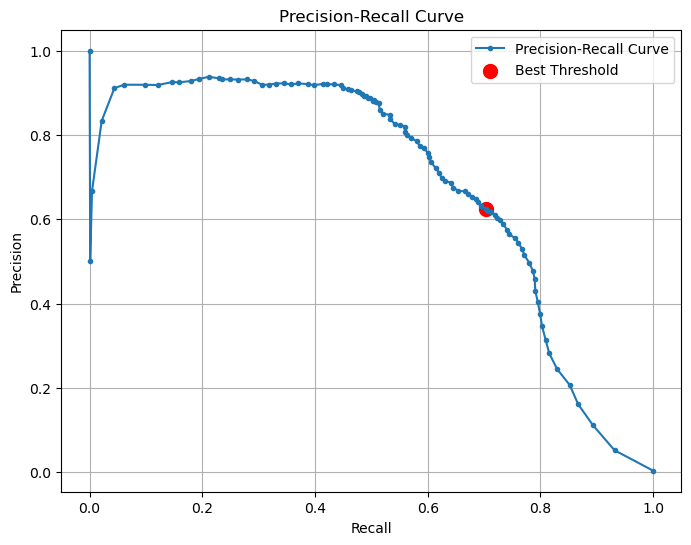

In [10]:
# Train and evaluate the Random Forest model
print("Evaluating Random Forest Model:")
trained_rf_model, best_rf_threshold, model_stats = evaluate_model_with_custom_threshold(random_forest,
                                                                        X_train, y_train, X_test, y_test,
                                                                        precision_min=0.35, recall_min=0.7)

In [11]:
import joblib

# Create a dictionary to store both the model and the threshold
model_and_threshold = {
    'model': trained_rf_model,
    'threshold': best_rf_threshold,
    'numeric_transformer': numeric_transformer,
    'target_encoder': target_encoder,
    'model_stats': model_stats
}

model_dir = '../storage/models/artifacts/random_forest_model_1'
os.makedirs(model_dir, exist_ok=True)

# Save the model and threshold together in a single file
filename = os.path.join(model_dir, 'model.pkl')
joblib.dump(model_and_threshold, filename)
print(f"Model and threshold saved to {filename}")

Model and threshold saved to ../storage/models/artifacts/random_forest_model_1/model.pkl


### Bagged Decision Tree Model


Evaluating Bagging Classifier Model:
Best Threshold: 0.39
F1-Score at Best Threshold: 72.39%
Precision at Best Threshold: 75.38%
Recall at Best Threshold: 69.64%


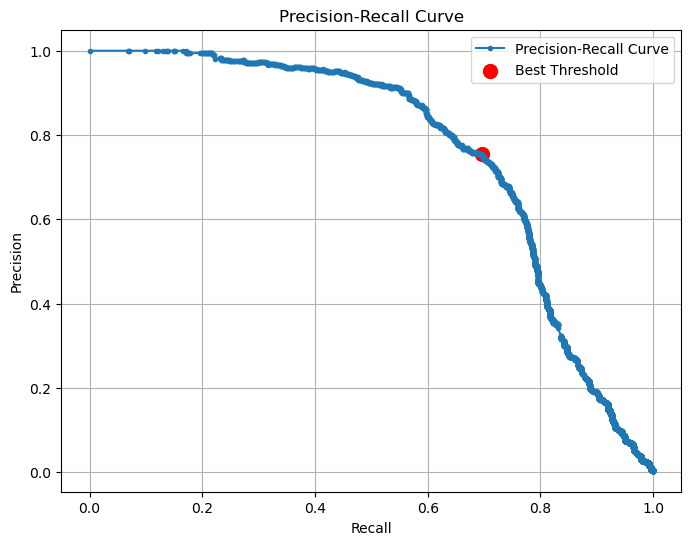

In [12]:
# Train and evaluate the Bagging Classifier model
print("\nEvaluating Bagging Classifier Model:")
trained_bagging_model, best_bagging_threshold, model_stats = evaluate_model_with_custom_threshold(bagging,
                                                                                X_train, y_train, X_test, y_test,
                                                                                precision_min=0.35, recall_min=0.65)

In [13]:
# Create a dictionary to store both the model and the threshold
model_and_threshold = {
    'model': trained_bagging_model,
    'threshold': best_bagging_threshold,
    'numeric_transformer': numeric_transformer,
    'target_encoder': target_encoder,
    'model_stats': model_stats
}


model_dir = '../storage/models/artifacts/bagging_model_1'
os.makedirs(model_dir, exist_ok=True)

# Save the model and threshold together in a single file
filename = os.path.join(model_dir, 'model.pkl')
joblib.dump(model_and_threshold, filename)
print(f"Model and threshold saved to {filename}")

Model and threshold saved to ../storage/models/artifacts/bagging_model_1/model.pkl


## Extra Trees Classifier


Evaluating Extra Trees Classifier Model:
Best Threshold: 0.16
F1-Score at Best Threshold: 52.13%
Precision at Best Threshold: 43.17%
Recall at Best Threshold: 65.77%


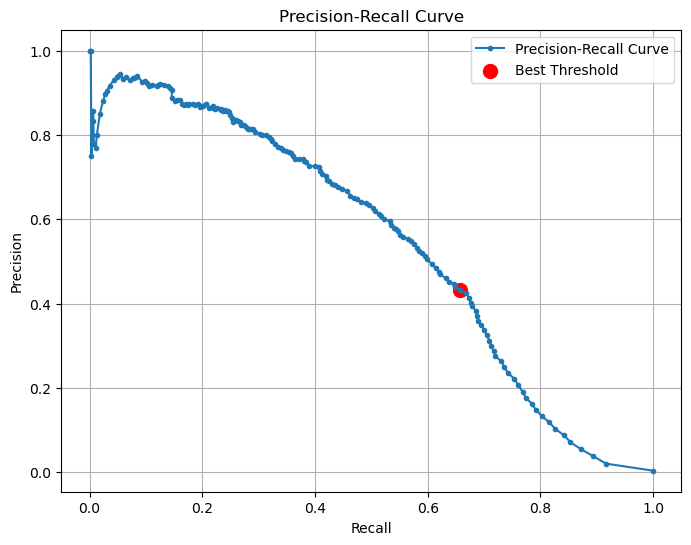

In [14]:
# Train and evaluate the Extra Trees Classifier model
print("\nEvaluating Extra Trees Classifier Model:")
trained_extratrees_model, best_extratrees_threshold, model_stats = evaluate_model_with_custom_threshold(extra_trees,
                                                                        X_train, y_train, X_test, y_test,
                                                                        precision_min=0.35, recall_min=0.65)

In [15]:
# Create a dictionary to store both the model and the threshold
model_and_threshold = {
    'model': trained_extratrees_model,
    'threshold': best_extratrees_threshold,
    'numeric_transformer': numeric_transformer,
    'target_encoder': target_encoder,
    'model_stats': model_stats
}

model_dir = '../storage/models/artifacts/extratrees_model_1'
os.makedirs(model_dir, exist_ok=True)

# Save the model and threshold together in a single file
filename = os.path.join(model_dir, 'model.pkl')
joblib.dump(model_and_threshold, filename)
print(f"Model and threshold saved to {filename}")

Model and threshold saved to ../storage/models/artifacts/extratrees_model_1/model.pkl
